In [1]:
import math

# Faces para bissetriz de polígonos maiores que 4 lados

decisao_de_faces = 0

# Carrega o arquivo shapefile

import geopandas as gpd

gdf = gpd.read_file('C:\\Users\\Estrela\\Desktop\\Método das Bissetrizes\\shapefiles\\quadras_shapefile\\quadras.shp')

# Reprojeta as geometrias para um CRS projetado

gdf = gdf.to_crs(gdf.crs)

from shapely.geometry import LineString

# Itera sobre as linhas do GeoDataFrame e imprime a área e as coordenadas dos vértices de cada polígono

for index, row in gdf.iterrows():
    if row['geometry'] is not None:
    
        # Usando o índice da linha como ID
        polygon_id = index

        # Obtendo área do polígono
        polygon_area = row['geometry'].area

        # Obtém as coordenadas dos vértices
        polygon_vertices = row['geometry'].exterior.coords
    
# Separando polígonos de 4 lados
  
gdf_inf = []

for i, row in gdf.iterrows():
    
    # Verifique se a geometria é um polígono com quatro coordenadas (vértices)
    
    if row['geometry'].geom_type == 'Polygon':
        gdf_inf.append(row)

# Separando vértices dos polígonos
        
poligonos = []
        
for i, coluna in enumerate(gdf_inf):
    
    # Polígonos
    poligonos.append([])

    for vertice in coluna['geometry'].exterior.coords:

        # Vertices do polígono
        poligonos[i].append((vertice[0], vertice[1]))

In [2]:
# Inclinação e comprimento de retas

def inclinacoes_e_comprimentos_de_retas(poligonos):

    inclinacoes = []
    comprimentos = []

    for i in range(len(poligonos)):

        # Lista que representa um polígono
        inclinacoes.append([])
        comprimentos.append([])

        for j in range(len(poligonos[i]) - 1):

            # Cálculo das inclinações do polígono pela equação: m = (y2 - y1) / (x2 - x1)     
            if (poligonos[i][j + 1][1] == poligonos[i][j][1]) or (poligonos[i][j + 1][0] == poligonos[i][j][0]):
                inclinacoes[i].append(0)

            else:    
                inclinacoes[i].append( (poligonos[i][j + 1][1] - poligonos[i][j][1]) / 
                                       (poligonos[i][j + 1][0] - poligonos[i][j][0]) )
 
            # Cálculo dos comprimentos das retas do polígono pela equação: d = [(x2 - x1)² + (y2 - y1)²]^(1/2)
            comprimentos[i].append(((poligonos[i][j + 1][1] - poligonos[i][j][1])**2 + (poligonos[i][j + 1][0] - poligonos[i][j][0])**2)**(1/2))

        # Adicionando primeira inclinação à lista para facilitar cálculo do ângulo dos vértices
        inclinacoes[i].append(inclinacoes[i][0])
        
    return inclinacoes, comprimentos

inclinacoes, comprimentos = inclinacoes_e_comprimentos_de_retas(poligonos)

In [22]:
# Decidindo lados onde sairão retas que irão se cruzar (Polígono de 4 lados)

def lados_das_retas_das_bissetrizes(comprimentos):

    lados_das_retas = []

    for i in range(len(comprimentos)):
        
        # Menores faces do polígono
                
        # Polígono de 4 lados
        if len(comprimentos[i]) == 4:
            
            if (comprimentos[i][0] + comprimentos[i][2]) < (comprimentos[i][1] + comprimentos[i][3]):
                lados_das_retas.append((0, 2))

            else:
                lados_das_retas.append((1, 3))
                
        # Polígono de 3 lados                
        elif len(comprimentos[i]) == 3:
            lados_das_retas.append((None, None))
        
        # Polígono maior que 4 lados 
        else:
            
            soma_de_comprimentos, ponteiro = [[],2]
            
            for j in range(len(comprimentos[i])):
                                
                if ponteiro == len(comprimentos[i]):
                    ponteiro = 0
                
                soma_de_comprimentos.append([comprimentos[i][j] + comprimentos[i][ponteiro], (j, ponteiro)])
                
                ponteiro += 1
                
            if decisao_de_faces == 0:    
                soma_de_comprimentos.remove(min(soma_de_comprimentos, key=lambda lista: lista[0]))                        
                lados_das_retas.append((min(soma_de_comprimentos, key=lambda lista: lista[0]))[1])
                
            elif decisao_de_faces == 1:     
                soma_de_comprimentos = sorted(soma_de_comprimentos, key=lambda lista: lista[0], reverse=True) 
                lados_das_retas.append(soma_de_comprimentos[int(len(soma_de_comprimentos) / 2)][1])
                
            else:
                soma_de_comprimentos.remove(max(soma_de_comprimentos, key=lambda lista: lista[0]))
                lados_das_retas.append((max(soma_de_comprimentos, key=lambda lista: lista[0]))[1])
                            
    return lados_das_retas

lados_das_retas = lados_das_retas_das_bissetrizes(comprimentos)

In [23]:
# Calculando ângulos

def angulos_de_um_poligono(inclinacoes):

    angulos_grd = []
    angulos_rad = []

    for i in range(len(inclinacoes)):

        # Lista que representa um polígono
        angulos_grd.append([])
        angulos_rad.append([])

        for j in range(len(inclinacoes[i]) - 1):

            # Cálculo dos ângulos dos vertices do polígono em radianos: arctan(θ) = (180 / π) * [(m2 - m1) / (1 + m2 * m1)]
            angulo = (180 / math.pi) * math.atan((inclinacoes[i][j + 1] - inclinacoes[i][j]) / (1 + inclinacoes[i][j + 1] * inclinacoes[i][j]))

            if angulo < 0:
                angulo += 180

            angulos_grd[i].append(angulo)

            # Cálculo dos ângulos dos vertices do polígono em radianos: θ° * π / 180
            angulos_rad[i].append((math.pi / 180) * angulo)

        angulos_grd[i].insert(0, angulos_grd[i][-1])
        angulos_rad[i].insert(0, angulos_rad[i][-1])
        
    return angulos_grd, angulos_rad
    
angulos_grd = angulos_de_um_poligono(inclinacoes)[0]

In [24]:
# Rotacionando reta até ela se transformar na reta da bissetriz

def retas_de_bissetrizes(poligonos, angulos_grd):

    '''
    O cálculo da reta da bissetriz é feita da seguinte forma: O quadrilatero possui os pontos A, B, C 
    e D. Cada ponto possui um ângulo. Para encontrar a reta da bissetriz do ponto A, a reta AB é rota
    cionada em metade do grau do ângulo do vértice A no sentido horário. O ponto A se mantém fixo e o
    ponto B será rotacionado. Daí então será calculada a reta da bissetriz. A reta das bissetrizes do
    s outros pontos serão calculados da mesma forma.
    '''

    bissetrizes = []
    
    for i in range(len(poligonos)):
        bissetrizes.append([])

        for j in range(len(angulos_grd[i]) - 1):

            # Ângulo inverso, para calcular bissetriz da reta pelo sentido horário
            angulo_inverso = - math.radians(angulos_grd[i][j] / 2)  # Ângulo de rotação em radianos

            # Vetor da reta da bissetriz
            vetor = (poligonos[i][j+1][0] - poligonos[i][j][0], poligonos[i][j+1][1] - poligonos[i][j][1])

            # Calculando ponto que traça reta da bissetriz
            delta_x_rot = vetor[0] * math.cos(angulo_inverso) - vetor[1] * math.sin(angulo_inverso)
            delta_y_rot = vetor[0] * math.sin(angulo_inverso) + vetor[1] * math.cos(angulo_inverso)

            # Extraindo as coordenadas da reta da bissetriz
            bissetrizes[i].append((poligonos[i][j][0] + delta_x_rot, poligonos[i][j][1] + delta_y_rot))

        bissetrizes[i].append(bissetrizes[i][0])

    return bissetrizes

bissetrizes = retas_de_bissetrizes(poligonos, angulos_grd)

In [25]:
from sympy import symbols, Eq, solve

def ponto_de_interseccao_de_retas(poligonos, bissetrizes, lados_das_retas):

    # Intersecções das retas com menores distâncias entre si

    pontos_de_interseccao = []

    for i in range(len(poligonos)):
        pontos_de_interseccao.append([])
        
        if len(poligonos[i]) == 4:
            retas_que_se_tocam = 3
        else:
            retas_que_se_tocam = 2

        for j in range(retas_que_se_tocam): 
            
            if len(poligonos[i]) == 4:
                ponteiro = j
            else:
                ponteiro = lados_das_retas[i][j]

            # Definindo as variáveis simbólicas
            x, y = symbols('x y')

            # Definindo as equações das retas              
            p1r1 = poligonos[i][ponteiro]
            p2r1 = bissetrizes[i][ponteiro]

            p1r2 = poligonos[i][ponteiro+1]
            p2r2 = bissetrizes[i][ponteiro+1]

            equacao1 = Eq(y - (p2r1[1] - p1r1[1]) / (p2r1[0] - p1r1[0]) * x, p1r1[1] - (p2r1[1] - p1r1[1]) / (p2r1[0] - p1r1[0]) * p1r1[0])
            equacao2 = Eq(y - (p2r2[1] - p1r2[1]) / (p2r2[0] - p1r2[0]) * x, p1r2[1] - (p2r2[1] - p1r2[1]) / (p2r2[0] - p1r2[0]) * p1r2[0])

            # Resolvendo o sistema de equações para encontrar o ponto de intersecção
            ponto_de_interseccao = solve((equacao1, equacao2), (x, y))

            # Extraindo as coordenadas do ponto de intersecção
            pontos_de_interseccao[i].append((ponto_de_interseccao[x], ponto_de_interseccao[y]))

    return pontos_de_interseccao

pontos_de_interseccao = ponto_de_interseccao_de_retas(poligonos, bissetrizes, lados_das_retas)

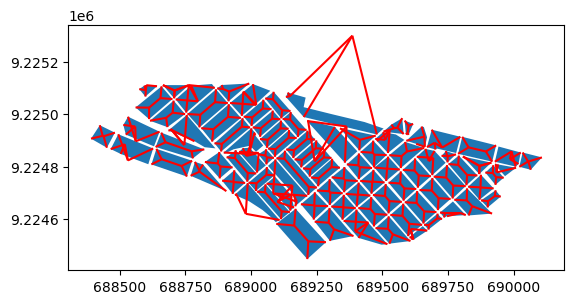

In [26]:
# Alocando linhas das bissetrizes nos polígonos

from shapely.geometry import LineString

coordenadas_das_linhas = []

for i in range(len(poligonos)):
    
    if len(poligonos[i]) == 4:
        retas_que_se_tocam = 3
    else:
        retas_que_se_tocam = 2
        
    for j in range(retas_que_se_tocam):
        
        if len(poligonos[i]) == 4:
            ponteiro = j
        else:
            ponteiro = lados_das_retas[i][j]
                
        coordenadas_das_linhas.append([poligonos[i][ponteiro], pontos_de_interseccao[i][j]])
        coordenadas_das_linhas.append([poligonos[i][ponteiro+1], pontos_de_interseccao[i][j]])
        
    if retas_que_se_tocam == 2:       
        coordenadas_das_linhas.append([pontos_de_interseccao[i][j-1], pontos_de_interseccao[i][j]])   

# Criando objetos LineString a partir das coordenadas
linhas = [LineString(coords) for coords in coordenadas_das_linhas]

# Criando um novo GeoDataFrame com as linhas
novo_gdf = gpd.GeoDataFrame({"geometry": linhas}, crs=gdf.crs)

# Salve o novo GeoDataFrame como um shapefile
novo_gdf.to_file('C:\\Users\\Estrela\\Desktop\\Método das Bissetrizes\\shapefiles\\novo_shapefile.shp')

# Plote o shapefile original e as novas linhas
ax = gdf.plot()
novo_gdf.plot(ax=ax, color='red')

# Exiba o gráfico
import matplotlib.pyplot as plt
plt.show()